In this notebook, we are going to demonstrate a few supervised machine learning algorithms for multi-class classification problems. You will be familiar with how to individually train and make predictions with each algorithm and how to compare them using cross validation to pick the best method for this problem.

We will use a data set from the scikit-learn API which consists of a number of attributes of wine (the features) such as the alcohol volume and colour. The dataset contains three types of wine (which we can treat as the labels or target). In this problem we are attempting to use machine learning for building a wine type classification model.

In [1]:
# import libraries
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# ML Algorithm and Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Loading the Data


To load the data and convert it to a pandas `DataFrame` use the code shown below.

In [2]:
wine = load_wine()
data = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])
data['target'] = wine['target']
print('data shape is:', data.shape)
data.head()

data shape is: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# Getting to know the data

Lets get some information about our data!

In [3]:
# check numerical variables statistical info
data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [4]:
# check the variable types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [5]:
# check null values
data.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [6]:
# check the target variable
data.target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

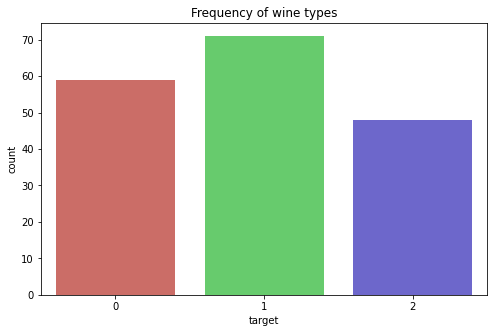

In [7]:
# visualized target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data, palette='hls')
plt.title('Frequency of wine types')
plt.show()

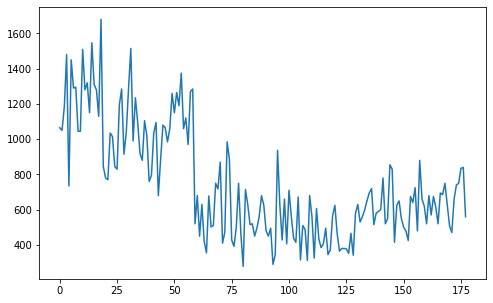

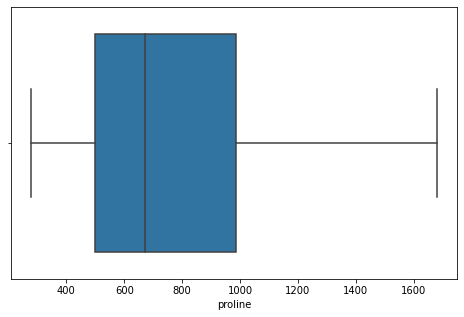

In [8]:
# visualize one numerical variable
plt.figure(figsize=(8, 5))
data.proline.plot()
plt.figure(figsize=(8, 5))
sns.boxplot(x='proline', data=data)

# Data Division 

As machine learning algorithms are based on mathematics, the data for machine learning must be in a numeric representation. This data set is entirely numeric, however, if we had categorical features we would need to perform some preprocessing to convert them to a numeric representation first. We have chosen this data set to explain the simplest workflow required to develop a model. A more in-depth look at common preprocessing techniques can be experienced in the first workshop.

We separate the data using a **Test train split** to ensure valid evaluation. It is important that the data is randomly split so that you are getting a good representation of the patterns that exist in the data in both sets (and not biased by some human assumption). Note that the randomness requirement may have to be relaxed if the data has a group collection dependency (like multiple samples being taken from the same patient in a health care problem) or a time dependency (like forecast problems will need to be split so that all training data comes before all test data).

In [9]:
y = data['target']
X = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('Train and Test data and target shapes are: \n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Train and Test data and target shapes are: 
 (142, 13) (142,) (36, 13) (36,)


It is a good idea to next train a dummy classifier to get a baseline score to benchmark further iterations of model development. Scikit-learn has a function that allows you to train a model and make predictions based on simple rules, such as predicting at random. This is useful to evaluate that your model development is improving as you iterate through the next steps.

# Hyperparameter Optimisation and Train the Baseline Classifier (Dummy)

**Hyperparameter optimisation**

Each machine learning algorithm has a variety of "hyperparameters" that are used to control the learning process. These hyperparameters can be changed and depending on the data set can result in an increase in performance for the model. The process of finding the best set of hyperparameters for an algorithm and data set is known as hyperparameter optimisation.

A common method to use for hyperparameter optimisation is called **grid search**. Scikit-learn provides a function to perform this called `GridSearchCV`. We need to pass this function a grid in the form of a python dictionary containing the hyperparameter names and the corresponding list of values to search over. This then becomes the hyperparameter space in which the function will search.

In [10]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('dummy', DummyClassifier(random_state=1254))
                 ])
parameters = {'dummy__strategy': ['most_frequent', 'uniform']}
grid = GridSearchCV(pipe, cv=10, param_grid=parameters, scoring='accuracy')
grid.fit(X_train, y_train)
print('Baseline Accuracy Score is:', grid.score(X_test, y_test))

Baseline Accuracy Score is: 0.4444444444444444


# Training and comparing a list of ML classifiers

Now that we have a baseline model trained, we need to evaluate if there is another algorithm that may perform better for wine type classification using this data. Scikit-learn has this useful cheat sheet (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) that will give you an idea of the different algorithms available to solve a classification problem.


The following scrip loops through a selection of classification algorithms and prints the classification resulting scores. The output is shown below the code. We have to choose the best performing classifier.


In [11]:
# prepare models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB',GradientBoostingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'f1_micro'
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
for name, model in models:
  kfold = model_selection.KFold(n_splits=10)
  cv_results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: 0.958571 (0.069532)
SVM: 0.979048 (0.032029)
RF: 0.979048 (0.032029)
GB: 0.950476 (0.064143)


# Overfitting Check


When developing a machine learning model it is important to be able to evaluate how accurate it is able to make predictions. However, if you use data that the model has already seen (during training for example) to evaluate the performance then you will not be able to detect such problems as **overfitting**. 

**Overfitting** is when a model has learned either too much detail or noise in the training data which won’t necessarily exist in unseen data. This is often referred to as the model having poor "generalization".

Lets check just one of the algorithms used above to see if there is any overfitting happening. We typically do this by looking for extreme differences in the training and test scores.

In [12]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())
                 ])
parameters = {'knn__n_neighbors':[3]}
grid = GridSearchCV(pipe, cv=10, param_grid=parameters, scoring='f1_micro')

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
grid.fit(X_train, y_train)
print('Train Performance Score is:', grid.score(X_train, y_train))
print('Test Performance Score is:', grid.score(X_test, y_test))

Train Performance Score is: 0.9647887323943662
Test Performance Score is: 0.9444444444444444


# Hyperparameter Optimisation for RF


By comparing the results of different algorithms above, we can observe that the Random Forest (RF) has the best performance on the training data. However, the rest of the methods also have shown close results, which suggests that the features themselves are highly predictive of the label. 

In this section we want to see how we can find the best hyperparameter values for our best ML classifier for this problem.

In [13]:
# require parmaeters for RF
n_estimators = [10, 20]
max_depth = [5, 8]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 5]
seed = 7
# make parameter space
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

# define our model and train it using gridsearchCV
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=seed), scoring='f1_micro')
best_model = grid_search.fit(X_train, y_train)
print('testing performance:', round(best_model.score(X_test, y_test),2))
print('selected hyperparam values:', best_model.best_params_)
y_pred_best = best_model.predict(X_test)
print('Evaluation on test data (Classification Report):\n', classification_report(y_test, y_pred_best))

testing performance: 0.97
selected hyperparam values: {'max_depth': 8, 'n_estimators': 20}
Evaluation on test data (Classification Report):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        16
           2       0.86      1.00      0.92         6

    accuracy                           0.97        36
   macro avg       0.95      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36



# Feature Importance Plot


In many (business) cases it is equally important to not only have an accurate, but also an interpretable ML model. Oftentimes, apart from wanting to know what our model’s prediction is, we also wonder why it is this high/low and which features are most important in determining this prediction.

Knowing feature importance indicated by machine learning models can benefit you in multiple ways:
* by getting a better understanding of the model’s logic you can not only verify it being correct but also work on improving the model by focusing only on the important variables
* The above can be used for variable selection — you can remove x variables that are not that significant and have similar or better performance in much shorter training time
* In some business cases it makes sense to sacrifice some accuracy for the sake of interpretability. 

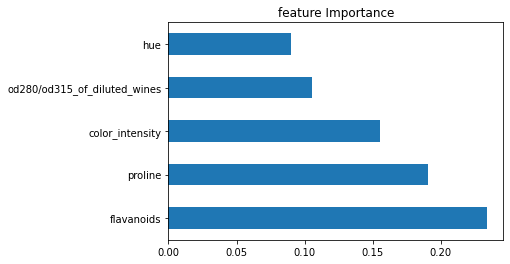

In [14]:
# show feature importance plot
(pd.Series(best_model.best_estimator_.feature_importances_, index=X_train.columns)
   .nlargest(5)
   .plot(kind='barh', title= "feature Importance"))    

# Feature Selection


What do we do if we want to use some feature selection or dimensionality reduction method along with our supervised machine learning algorithm?


Here we just choose a small ragne of values as you can see because otherwise running the program would take time. However feel free to play around with hyper parameters values and let it run to see if you can improve the performance of this wine type classification model.

In [15]:
# best model using feature selection
n_estimators = [10, 20]
max_depth = [5, 8]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 5]
seed = 7
rf = RandomForestClassifier()
pca = PCA(n_components=3)
fs_rf_pipeline = Pipeline(steps=[('pca', pca), ('rf', rf)])
param_grid = {'rf__n_estimators': n_estimators, 'rf__max_depth': max_depth}

grid_search = GridSearchCV(estimator=fs_rf_pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed), scoring='f1_micro')
best_model = grid_search.fit(X_train, y_train)
print(round(best_model.score(X_test, y_test),2))
print(best_model.best_params_)
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

0.86
{'rf__max_depth': 8, 'rf__n_estimators': 20}
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.93      0.81      0.87        16
           2       0.56      0.83      0.67         6

    accuracy                           0.86        36
   macro avg       0.83      0.86      0.83        36
weighted avg       0.89      0.86      0.87        36



As you see the accuracy dropped cuz we just said choose 3 of features usinc PCA. Feel free to play around with that by adding more featues and even use other feature selection methods. A useful link can be find here:
https://scikit-learn.org/stable/modules/feature_selection.html

The scikit-learn documentation contains a useful resource for different machine learning algorithm evaluation metrics:
https://scikit-learn.org/stable/modules/model_evaluation.html